This is official pytorch tutorial: <a href=https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py> Blitz Tutorial<a>

What is done in this tutorial:
    1. Load and normalize the CIFAR10 training and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data

TORCHVISION:
    The torchvision package consists of popular datasets, model architectures,
    and common image transformations for computer vision.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# IMPORT THE CIFAR DATASET, SPLIT INTO TRAIN AND TEST AND NORMALIZE THE IMAGES
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


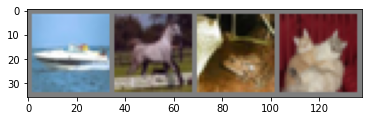

 ship horse  frog   cat


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [57]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    """ Define a model with two convolution layers each followed by a Max Pooling layer
    Then the embeddings are Flattened and forwarded into two FCls.
    The last layer is a FCL with 10 neurons.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 in channels, 6 out channels, kernel size 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # in channels -> 16 * 5 ^ 2 (kernel size 5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # WHERE IS SOFTMAX?
        return x


net = Net()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """ Define a model with two convolution layers each followed by a Max Pooling layer
    Then the embeddings are Flattened and forwarded into two FCls.
    The last layer is a FCL with 10 neurons.
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024, 512)  # in channels -> 16 * 5 ^ 2 (kernel size 5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()

In [55]:
import torch.optim as optim

# The function is indicating the performance of the model.
# During the training process this function should be minimized
criterion = nn.CrossEntropyLoss()

# The minimization is achieved through Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [58]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        """
        shape of inputs: torch.Size([4, 3, 32, 32])
            Batchsize: 4
            Channels: 3 (Red, Green, Blue)
            Image size: 32 x 32

        labels: tensor([9, 3, 0, 3])
            9: class of image 0 in batch
            3: class of image 1 in batch
            ...
        """
        inputs, labels = data

        """ zero the parameter gradients after every batch
        This is necessary because the gradients (directions of how the weigths and biases
        will be updated) are accumulated in each backward pass.
        https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        """
        optimizer.zero_grad()  # SGD

        # forward + backward + optimize
        # shape outputs: torch.Size([4, 10])
        # for every image a prediction
        outputs = net(inputs)
        # the first iteration CrossEntropy: tensor(2.3100, grad_fn=<NllLossBackward0>)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # running loss after 3 iterations: 6.894119024276733
        # Why is the loss added?
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {(running_loss / 2000):.3f}')
            running_loss = 0.0

print('Finished Training')
"""
[1, 2000] loss: 1.424
[1, 4000] loss: 1.413
[1, 6000] loss: 1.374
[1, 8000] loss: 1.327
[1, 10000] loss: 1.337
[1, 12000] loss: 1.314
[2, 2000] loss: 1.224
[2, 4000] loss: 1.257
[2, 6000] loss: 1.215
[2, 8000] loss: 1.240
[2, 10000] loss: 1.189
[2, 12000] loss: 1.210
Finished Training"""

[1, 2000] loss: 2.307
[1, 4000] loss: 2.308
[1, 6000] loss: 2.305
[1, 8000] loss: 2.307
[1, 10000] loss: 2.307
[1, 12000] loss: 2.304
[2, 2000] loss: 2.306
[2, 4000] loss: 2.308
[2, 6000] loss: 2.305
[2, 8000] loss: 2.307
[2, 10000] loss: 2.307
[2, 12000] loss: 2.305
Finished Training


'\n[1, 2000] loss: 1.424\n[1, 4000] loss: 1.413\n[1, 6000] loss: 1.374\n[1, 8000] loss: 1.327\n[1, 10000] loss: 1.337\n[1, 12000] loss: 1.314\n[2, 2000] loss: 1.224\n[2, 4000] loss: 1.257\n[2, 6000] loss: 1.215\n[2, 8000] loss: 1.240\n[2, 10000] loss: 1.189\n[2, 12000] loss: 1.210\nFinished Training'

In [35]:
PATH = './models/cifar_net_2epoch.pth'
torch.save(net.state_dict(), PATH)

### Evaluate the model on the test data
This could be done with TorchMetrics but we will do this manually here

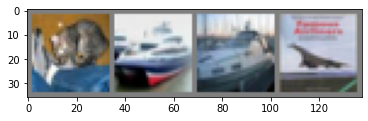

GroundTruth:    cat  ship  ship plane


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# here we are loading the net back in but this is not necessary
# it just demonstrates how to do so
net = Net()
net.load_state_dict(torch.load(PATH))

In [40]:
outputs = net(images)
outputs

tensor([[-0.5843, -1.1601, -0.1589,  2.5071, -1.9582,  2.4055,  0.3804, -0.3688,
          0.7142, -1.2553],
        [ 3.0227,  5.2401, -0.9592, -2.2541, -3.6933, -3.5725, -2.8663, -3.5914,
          3.6389,  3.5093],
        [ 1.6567,  1.9177,  0.5905, -0.9688, -1.4696, -1.7208, -2.9308, -1.1688,
          0.7966,  1.6736],
        [ 1.7278, -0.1858,  0.9835, -0.9314, -0.1562, -1.6915, -1.4836, -1.5618,
          2.0626, -0.2773]], grad_fn=<AddmmBackward0>)

In [50]:
"""
torch.max returns:
    torch.return_types.max(
    values=tensor([2.5071, 5.2401, 1.9177, 2.0626], grad_fn=<MaxBackward0>),
    indices=tensor([3, 1, 1, 8]))

The indices (classes) are at the first index
"""

_, predicted = torch.max(outputs, 1)

In [51]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# Accuracy of the network on the 10000 test images: 56 %

Accuracy of the network on the 10000 test images: 56 %


In [53]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))
"""
Accuracy for class plane is: 54.5 %
Accuracy for class car   is: 61.8 %
Accuracy for class bird  is: 60.0 %
Accuracy for class cat   is: 50.5 %
Accuracy for class deer  is: 55.8 %
Accuracy for class dog   is: 26.7 %
Accuracy for class frog  is: 63.0 %
Accuracy for class horse is: 54.7 %
Accuracy for class ship  is: 62.6 %
Accuracy for class truck is: 77.1 %
"""

Accuracy for class plane is: 54.5 %
Accuracy for class car   is: 61.8 %
Accuracy for class bird  is: 60.0 %
Accuracy for class cat   is: 50.5 %
Accuracy for class deer  is: 55.8 %
Accuracy for class dog   is: 26.7 %
Accuracy for class frog  is: 63.0 %
Accuracy for class horse is: 54.7 %
Accuracy for class ship  is: 62.6 %
Accuracy for class truck is: 77.1 %


Create hashsum